## Questão 1 - Prova 2 IA

1) Considere o jogo dos 8 números, tal como mostrado em sala de aula, no
qual problema consiste em: Dada uma configuração (estado) qualquer,
movimente as “peças” em direção a uma configuração alvo (estado
objetivo). Apresente uma solução, a este jogo, em pseudo-código
(linguagem algorítmica), inclusive dando detalhes da estrutura de dados
adotada, para cada um dos 3 seguintes algoritmos: (i) Algoritmo de busca
gulosa; (ii) algoritmo A* e (iii) algoritmo de subida de encosta. Mostre
como seria as possíveis execuções, com o passo a passo, para cada um dos
3 algoritmos, nas duas situações seguintes:

In [1]:
# Importação das bibliotecas usadas
from dataclasses import dataclass
import copy
from math import floor, sqrt
import secrets
from IPython.display import Image
import pygraphviz as pgv

### Definição dos Estados do Problema

In [2]:
# Construção da classe que representa um estado do jogo
@dataclass
class BoardState:

    board: list[list[int]]
    empty_pos: tuple[int, int]

    def __post_init__(self):
        """
        realiza verificações na pós inicialização do objeto
        """
        x,y = self.empty_pos
        if not self.__verify_pos((x,y)) or self.board[x][y] != 0:
            raise IndexError("Invalid empty position")

    def get_flatten_board(self) -> dict[int, tuple[int, int]]:
        """
        converte o tabuleiro em um dicionário valor : posição
        """
        flatten_board = {}
        for i in range(3):
            for j in range(3):
                value = self.board[i][j]
                flatten_board[value] = (i,j)
        return flatten_board

    def calc_score(self, goal_state: "BoardState", kind: str) -> int:
        """
        calcula score das peças em relação a um estado objetivo
        """

        def calc_manhattan(x1: int, y1: int, x2: int, y2: int) -> int:
            return abs(x1 - x2) + abs(y1 - y2)

        def calc_euclidian(x1: int, y1: int, x2: int, y2: int) -> int:
            return sqrt((x1 - x2)**2 + (y1 - y2)**2)

        func_mapping = {
            "manhattan" : calc_manhattan,
            "euclidian" : calc_euclidian
        }
        
        flatten_board = self.get_flatten_board()
        flatten_goal = goal_state.get_flatten_board()
        dist = 0
        for i in range(1, 9):
            x1, y1 = flatten_board[i]
            x2, y2 = flatten_goal[i]
            dist += func_mapping[kind](x1, y1, x2, y2)
        return floor(dist)
    
    def __verify_pos(self, pos: tuple[int,int]) -> bool:
        """
        verifica se uma posição do tabuleiro é válida
        """
        return 0 <= pos[0] < 3 and 0 <= pos[1] < 3

    def __repr__(self):
        board = "\n".join([str(line) for line in self.board]) 
        return f"board:\n{board}\nempty_pos: {self.empty_pos}"

    def __hash__(self):
        return hash(tuple(map(tuple,self.board)))

    def is_solvable(self, goal_state: "BoardState"):

        def count_inversions(state: "BoardState"):
            plan_board = [j for i in state.board for j in i]
            inv_count = 0
    
            for i in range(0,9):
                for j in range(i+1, 9):
                    if plan_board[j] != 0 and plan_board[i] != 0 and plan_board[i] > plan_board[j]:
                        inv_count += 1
            return inv_count

        self_inv = count_inversions(self)
        goal_inv = count_inversions(goal_state)

        return (self_inv % 2) == (goal_inv % 2)
    

    def get_neighbors(self) -> list["BoardState"]:
        """
        retorna os vizinhos do estado corrente
        """
        moves = [(-1,0),(1,0),(0,1),(0,-1)]
        x, y = self.empty_pos
        neighbors = []
        for move in moves:
            new_pos = (x + move[0], y + move[1])
            if not self.__verify_pos(new_pos):
                continue
            new_board = copy.deepcopy(self.board)
            nx, ny = new_pos
            new_board[x][y], new_board[nx][ny] = new_board[nx][ny], new_board[x][y]
            neighbors.append(BoardState(new_board, new_pos))
        return neighbors

    def get_graphviz_node(self, goal_state: "BoardState", heuristic: str,
                          g: dict | None = None, visited : bool = False) -> dict[str,any]:
        """
        retorna os dados necessários pra criação de um nó no pygraphviz
        """
        label = str(self) + f"\n"
        label += f"h = {self.calc_score(goal_state, heuristic)}" if not visited else "--"
        label += f", g={g[self]}" if g and not visited else ""
        return dict(
            n = hash(self) if not visited else secrets.token_hex(8),
            label = label,
            shape="box",
            style="bold", 
            color="blue" if not visited else "gray"
        )

In [3]:
# Alguns testes com a classe
board = BoardState([[2,8,3],[1,6,4],[7,5,0]], (2,2))
goal_state = BoardState([[1,2,3],[8,0,4],[7,6,5]], (1,1))
goal_state_2 = BoardState([[1,2,3],[8,0,4],[7,6,5]], (1,1))

In [24]:
board

board:
[2, 8, 3]
[1, 6, 4]
[7, 5, 0]
empty_pos: (2, 2)

In [4]:
print(hash(goal_state_2))
print(hash(goal_state))

4459469924218084483
4459469924218084483


In [5]:
board.calc_score(goal_state, kind="manhattan")

6

In [7]:
neighbors = board.get_neighbors()
neighbors

[board:
 [2, 8, 3]
 [1, 6, 0]
 [7, 5, 4]
 empty_pos: (1, 2),
 board:
 [2, 8, 3]
 [1, 6, 4]
 [7, 0, 5]
 empty_pos: (2, 1)]

In [8]:
for neighbor in neighbors:
    print(neighbor.calc_score(goal_state, kind = "manhattan"))

7
5


In [9]:
board.get_flatten_board()

{2: (0, 0),
 8: (0, 1),
 3: (0, 2),
 1: (1, 0),
 6: (1, 1),
 4: (1, 2),
 7: (2, 0),
 5: (2, 1),
 0: (2, 2)}

### Verificando viabilidade das entradas

A verificação de viabilidade de uma configuração do *8-puzzle* pode ser feita comparando a paridade do número de inversões.

- Uma **inversão** ocorre quando um número maior precede um número menor na lista linearizada do tabuleiro.
- Se a configuração inicial e o estado objetivo têm o mesmo tipo de paridade (ambas com um número par ou ambas com um número ímpar de inversões), então é **possível resolver** o puzzle, movendo-se de um para o outro. Se as paridades forem diferentes, então a configuração inicial **não é resolvível**.

In [10]:
board1_1 = BoardState([[1,7,2],[8,4,5],[6,3,0]], (2,2))
board1_2 = BoardState([[2,8,3],[1,6,4],[7,5,0]], (2,2))

In [11]:
print("Entrada 1 é resolvível? ", board1_1.is_solvable(goal_state))
print("Entrada 2 é resolvível? ", board1_2.is_solvable(goal_state))

Entrada 1 é resolvível?  False
Entrada 2 é resolvível?  True


### Construção dos Algoritmos

#### Algoritmo Hill Climb

Tentativa com algoritmo *Hill Climb* (Subida de Encosta) para a solução do *8-puzzle*,
usando distância Manhattan como heurística

```bash
FUNC hill_climb(estado_inicial, estado_objetivo) -> estado_maximo_local
    estado_atual := estado_inicial
    ENQUANTO estado_atual != estado_objetivo:
        estado_vizinho := melhor_sucessor_de(estado_atual)
        SE h(estado_vizinho) >= h(estado_atual):
            RETORNA estado_atual
        estado_atual = estado_vizinho
```


In [12]:
def hill_climb(start_state: BoardState, goal_state: BoardState, heuristic: str):
    """
    algoritmo Hill Climb para o problema 8-puzzle
    """
    steps = 0 # amrmazena a quantidade de passos (subidas)
    path = [start_state] # armazena o caminho
    current_state = start_state
    while current_state != goal_state:
        steps += 1
        neighbors = current_state.get_neighbors()
        neighbors_with_cost = [(n, n.calc_score(goal_state, heuristic)) for n in neighbors]
        best_neighbor, best_cost = sorted(neighbors_with_cost, key = lambda x: x[1])[0]

        if best_cost >= current_state.calc_score(goal_state, heuristic):
           break

        current_state = best_neighbor
        path.append(current_state)

    print(f"Máximo local encontrado em {steps} passos!")
    print(f"{current_state = }")
    return path

In [13]:
def get_hill_climb_path(path, goal_state, heuristic):
    """
    retorna grafo direcionado para o caminho encontrado com Hill Climb
    """
    graph = pgv.AGraph(directed=True)
    last_state = path[0]
    graph.graph_attr['rankdir'] = 'LR'
    pgv_params = last_state.get_graphviz_node(goal_state, heuristic = heuristic)
    graph.add_node(**pgv_params)
    for state in path[1:]:
        pgv_params = state.get_graphviz_node(goal_state, heuristic = heuristic)
        graph.add_node(**pgv_params)
        graph.add_edge(hash(last_state), hash(state))
        last_state = state
    return graph
        

In [14]:
path = hill_climb(board, goal_state, "manhattan")

Máximo local encontrado em 6 passos!
current_state = board:
[1, 2, 3]
[8, 0, 4]
[7, 6, 5]
empty_pos: (1, 1)


In [15]:
graph = get_hill_climb_path(path, goal_state, "manhattan")
graph.layout(prog='dot')
graph.draw('src/q1_2_hill_climb.png')

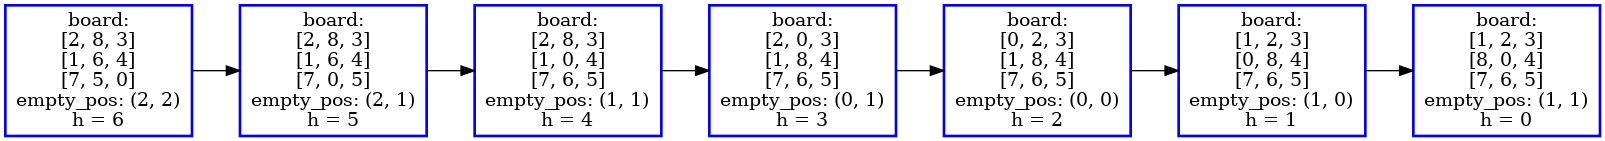

In [16]:
Image('src/q1_2_hill_climb.png')

#### Algoritmo Guloso

Tentativa com algoritmo guloso para a solução do *8-puzzle*,
usando distância Manhattan como heurística

```bash
FUNC greedy_algorithm(estado_inicial, estado_objetivo) -> solução
    visitados := [] # explorados
    fila_prioritaria := [(estado_inicial, h(estado_inicial))] # borda
    ENQUANTO fila_prioritaria tem elementos:
        estado_atual := fila_prioritaria.pop()
        SE estado_atual == estado_objetivo:
            RETORNA solução(estado_atual)

        visitados.add(estado_atual)
        PARA CADA vizinho DE estado_atual:
            SE vizinho NÃO está em visitados:
                fila_prioritaria.push((vizinho, h(vizinho)) # f(n) = h(n)
```

In [17]:
def get_path_and_graph(current_state, parent, graph):
    path = []
    while current_state is not None:
        node = graph.get_node(str(hash(current_state)))
        node.attr["color"] = "green"
        path.append(current_state)
        current_state = parent[current_state]
    path.reverse()
    return path, graph

In [18]:
def greedy_algorithm(start_state: BoardState, goal_state: BoardState, heuristic: str):
    steps = 0
    graph = pgv.AGraph()
    graph.graph_attr['rankdir'] = 'BT'
    visited = []
    graph.add_node(**start_state.get_graphviz_node(goal_state, heuristic = heuristic))
    queue = [(start_state, start_state.calc_score(goal_state, heuristic))]
    parent = {start_state: None}
    while queue:
        current_state, _ = queue.pop(0)
        if current_state not in visited:
            steps += 1
            
            if current_state == goal_state:
                print(f"No. steps: {steps}")
                return get_path_and_graph(current_state, parent, graph)
                
            visited.append(current_state)
            
            neighbors = current_state.get_neighbors()

            for state in neighbors:
                was_visited = state in visited
                if not was_visited:
                    parent[state] = current_state
                    queue.append((state, state.calc_score(goal_state, heuristic)))

                pgv_params = state.get_graphviz_node(goal_state, heuristic = heuristic, visited = was_visited)
                graph.add_node(**pgv_params)
                graph.add_edge(pgv_params.get("n"), hash(current_state))
                    

            queue = sorted(queue, key = lambda x: x[1])

In [19]:
path, graph = greedy_algorithm(board, goal_state, "manhattan")

graph.layout(prog='dot')  # Usa o layout 'dot'
graph.draw('src/q1_2_greedy.png')

No. steps: 7


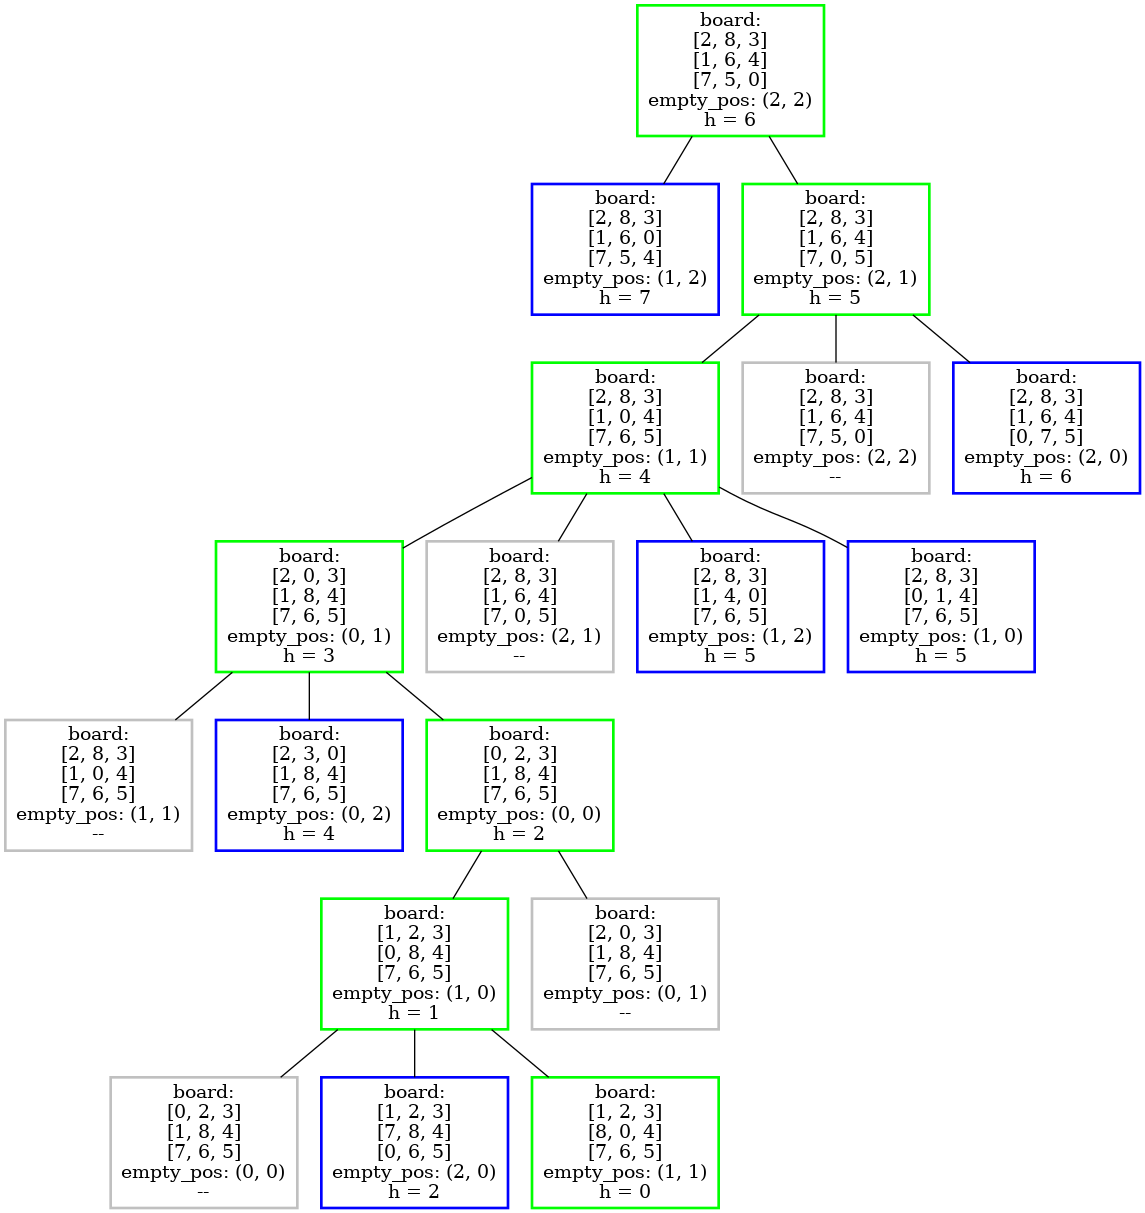

In [20]:
Image('src/q1_2_greedy.png')

#### Algoritmo A*

Tentativa com algoritmo A* para a solução do *8-puzzle*,
usando distância Manhattan como heurística

```bash
FUNC astar_algorithm(estado_inicial, estado_objetivo) -> solução
    visitados := [] # explorados
    g := {estado_inicial: 0} # g(n)
    fila_prioritaria := [(estado_inicial, h(estado_inicial))] # borda
    ENQUANTO fila_prioritaria tem elementos:
        estado_atual := fila_prioritaria.pop()
        SE estado_atual == estado_objetivo:
            RETORNA solução(estado_atual)

        visitados.add(estado_atual)
        PARA CADA vizinho DE estado_atual:
            custo_caminho := g[estado_atual] + 1 
            SE vizinho NÃO está em g OU custo_caminho < g[vizinho]:
                g[vizinho] = custo_caminho
                SE vizinho NÃO está em visitados:
                    fila_prioritaria.push((vizinho, h(vizinho) + g(vizinho)) # f(n) = h(n) + g(n)
```

In [21]:
def a_star(start_state: BoardState, goal_state: BoardState, heuristic: str):
    if start_state == goal_state:
        return True
    steps = 0
    visited = []
    graph = pgv.AGraph()
    graph.graph_attr['rankdir'] = 'BT'
    queue = [(start_state, start_state.calc_score(goal_state, heuristic))]
    parent = {start_state: None}
    g = {start_state: 0}
    graph.add_node(**start_state.get_graphviz_node(goal_state, g = g, heuristic = heuristic))
    while queue:
        current_state, _ = queue.pop(0)
        if current_state not in visited:
            steps += 1
            if current_state == goal_state:
                print(f"No. steps: {steps}")
                return get_path_and_graph(current_state, parent, graph)
                
            visited.append(current_state)
            
            neighbors = current_state.get_neighbors()

            for state in neighbors:
                score = g[current_state] + 1
                was_visited = state in visited
                if state not in g or score < g[state]:
                    parent[state] = current_state
                    g[state] = score
                    if not was_visited:
                        queue.append((state, state.calc_score(goal_state, heuristic) + g[state]))
                pgv_params = state.get_graphviz_node(goal_state, heuristic = heuristic, visited = was_visited, g = g)
                graph.add_node(**pgv_params)
                graph.add_edge(pgv_params.get("n"), hash(current_state))

            queue = sorted(queue, key = lambda x: x[1])

In [22]:
path, graph = a_star(board, goal_state, "manhattan")

graph.layout(prog='dot') 
graph.draw('src/q1_2_astar.png')

No. steps: 7


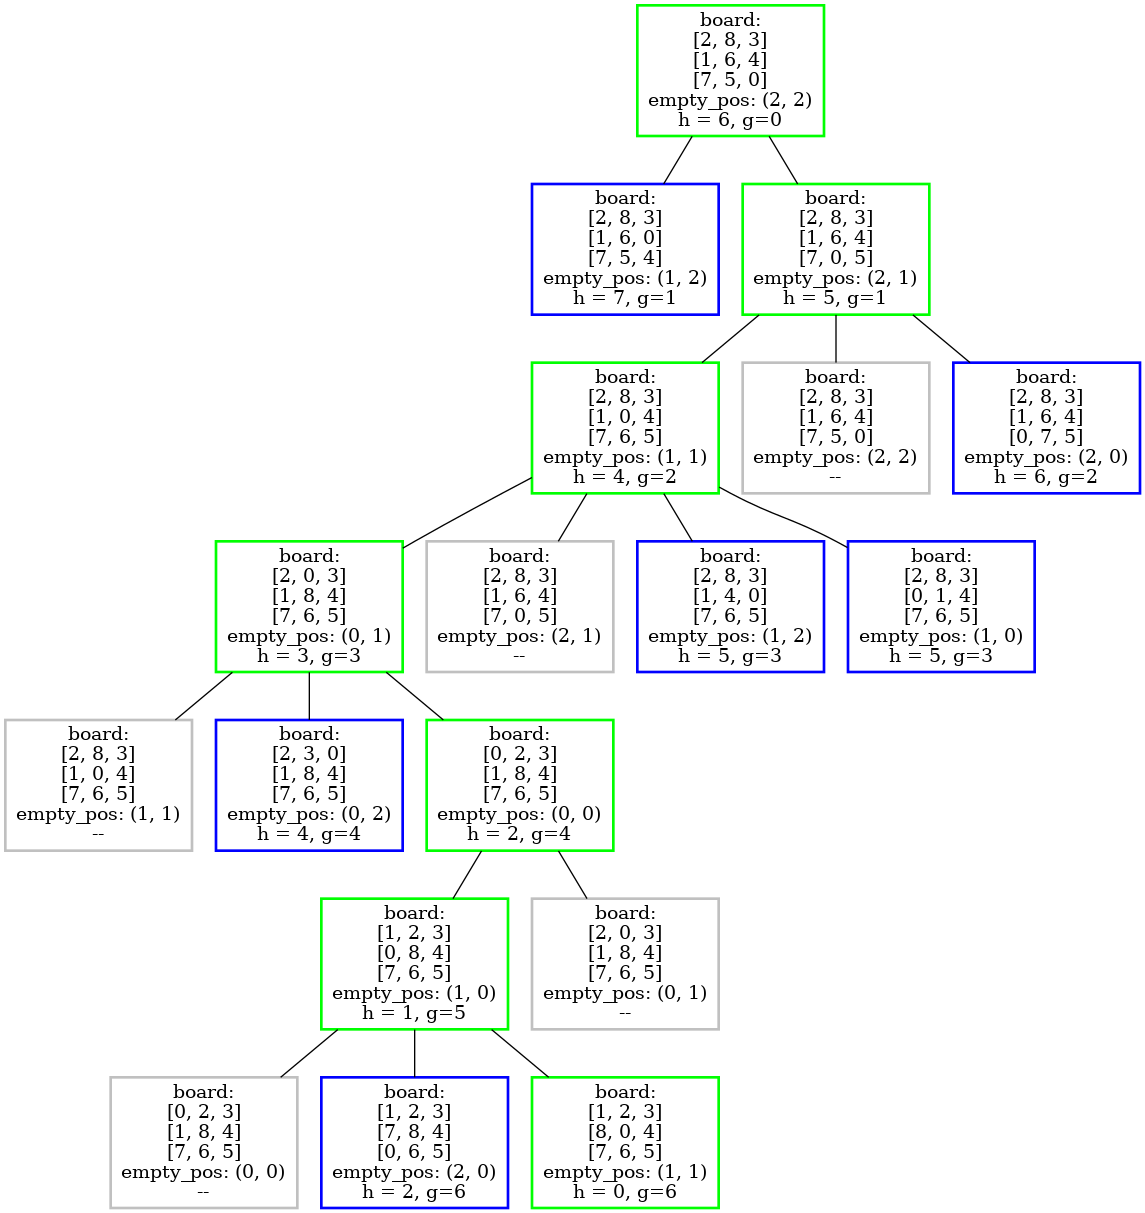

In [23]:
Image("src/q1_2_astar.png")

In [25]:
path, graph = a_star(board, goal_state, "euclidian")

graph.layout(prog='dot') 
graph.draw('src/q1_2_astar_euclidian.png')

No. steps: 8


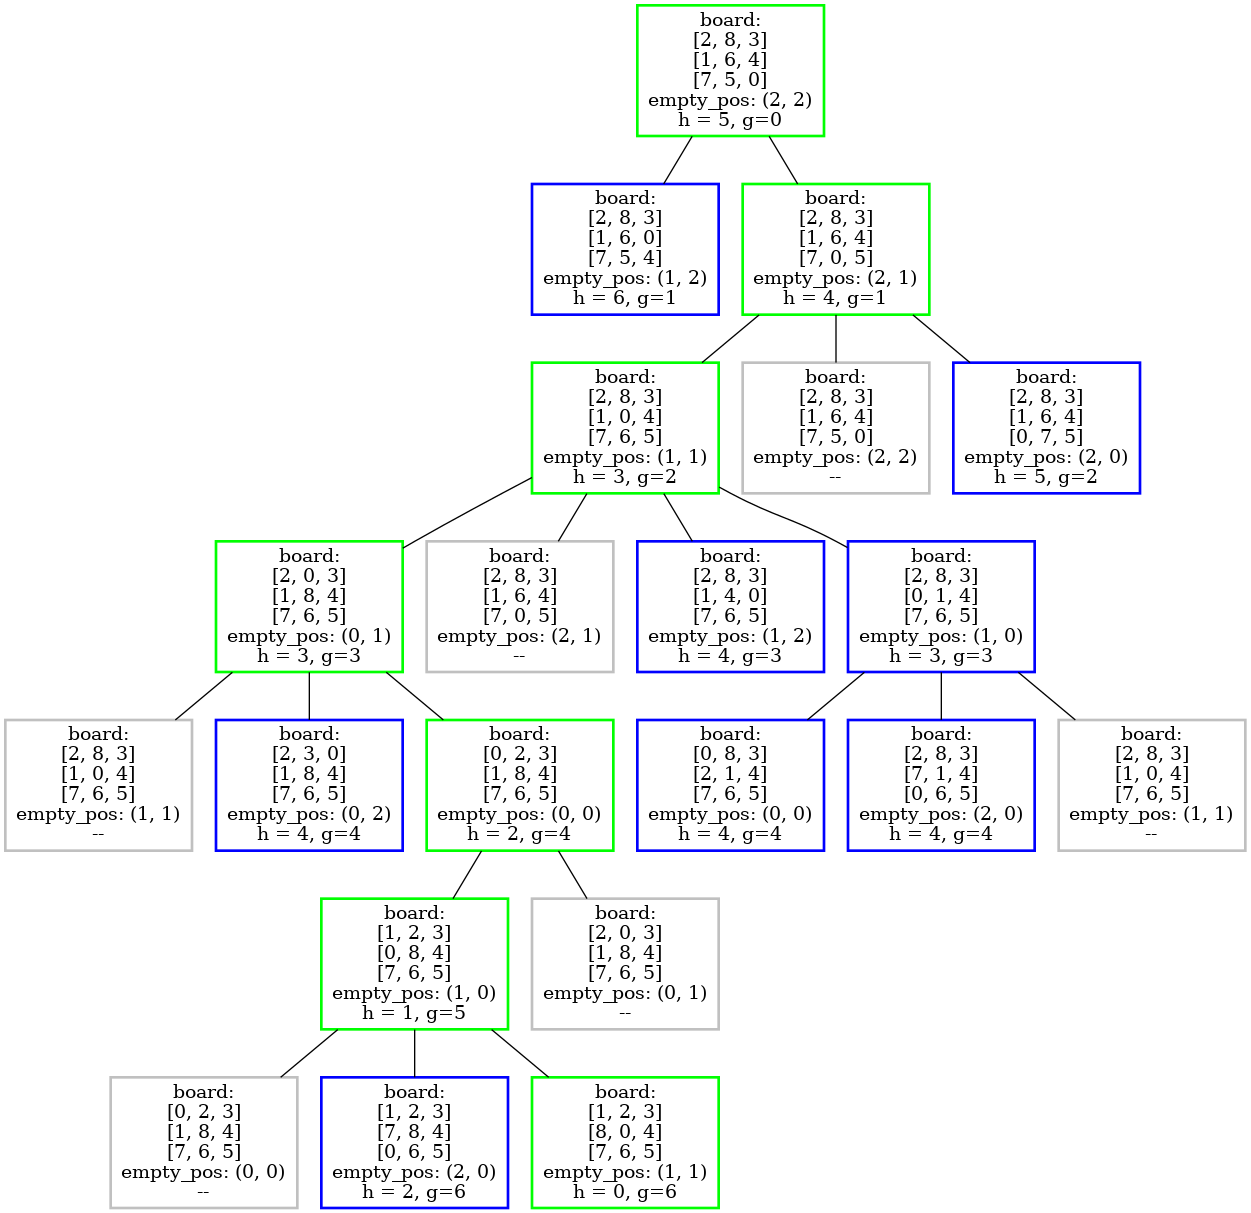

In [26]:
Image("src/q1_2_astar_euclidian.png")